# Week 9: Understanding LLM Hallucination Through Next-Token Prediction

**Goal**: Understand why Large Language Models (LLMs) hallucinate by exploring the fundamental mechanism of next-token prediction.

---

## Part 1 — Concept: What Is Next-Token Prediction?

### Core Ideas:

1. **LLMs predict the probability distribution of the next token based on previous context at each step**
   - Token: The basic unit of text (can be a word, subword, or character)
   - Probability distribution: `p(token | previous tokens)`

2. **Generation = Continuous next-step prediction**
   ```
   Input: "The capital of France"
   → Prediction: "is" (probability 0.8)
   → New input: "The capital of France is"
   → Prediction: "Paris" (probability 0.95)
   ```

3. **Key point: Language Model ≠ Fact Model**
   - LLMs don't know facts, they only select the most probable next token
   - When context is ambiguous, multiple high-probability candidates emerge, making it easier to "fabricate" content

### Mathematical Expression:
$$P(\text{token}_i | \text{token}_1, \text{token}_2, ..., \text{token}_{i-1})$$

---

In [1]:
# Setup: Import necessary libraries
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import warnings
warnings.filterwarnings('ignore')

# Import from our toolkit
from ccai9012.llm_utils import initialize_llm, ask_llm
from ccai9012.sd_utils import get_hf_api_key

In [2]:
hf_token = get_hf_api_key()

model_name = "EleutherAI/gpt-neo-1.3B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_token)
model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=hf_token)

print(f"Loaded {model_name} successfully!")

Enter your HUGGINGFACE_API_KEY:  ········


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

Loaded EleutherAI/gpt-neo-1.3B successfully!


In [7]:
def get_next_token_probabilities(prompt, tokenizer, model, top_k=10):
    """
    Get the top-k most probable next tokens and their probabilities.
    
    Args:
        prompt (str): Input text
        tokenizer: Hugging Face tokenizer
        model: Hugging Face language model
        top_k (int): Number of top tokens to return
    
    Returns:
        tuple: (tokens, probabilities)
    """
    # Tokenize input
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # Get model output (logits)
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
    
    # Get logits for the last token (next token prediction)
    next_token_logits = logits[0, -1, :]
    
    # Convert logits to probabilities using softmax
    probabilities = torch.softmax(next_token_logits, dim=0)
    
    # Get top-k tokens
    top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # Decode tokens
    top_tokens = [tokenizer.decode([idx]) for idx in top_indices]
    
    return top_tokens, top_probs.numpy()

## Part 2 — Example 1: Clear, Unambiguous Prompt

**Hypothesis**: When the prompt is clear and unambiguous, the model should show a **strongly peaked probability distribution** with one dominant token.

**Prompt**: "The capital of France is"

**Expected behavior**: "Paris" should have extremely high probability.

In [4]:
# Example 1: Clear, unambiguous prompt
# prompt1 = "1 + 1 ="
prompt1 = "The capital of France is"

tokens1, probs1 = get_next_token_probabilities(prompt1, tokenizer, model, top_k=10)

print(f"Prompt: '{prompt1}'\n")
print("Top 10 next-token predictions:")
print("-" * 40)
for token, prob in zip(tokens1, probs1):
    print(f"{token:20s} → {prob:.4f} ({prob*100:.2f}%)")

Prompt: 'The capital of France is'

Top 10 next-token predictions:
----------------------------------------
 Paris               → 0.1830 (18.30%)
 the                 → 0.1050 (10.50%)
 a                   → 0.0743 (7.43%)
 not                 → 0.0436 (4.36%)
 in                  → 0.0421 (4.21%)
 one                 → 0.0183 (1.83%)
 called              → 0.0176 (1.76%)
 about               → 0.0160 (1.60%)
 Mont                → 0.0133 (1.33%)
 located             → 0.0098 (0.98%)


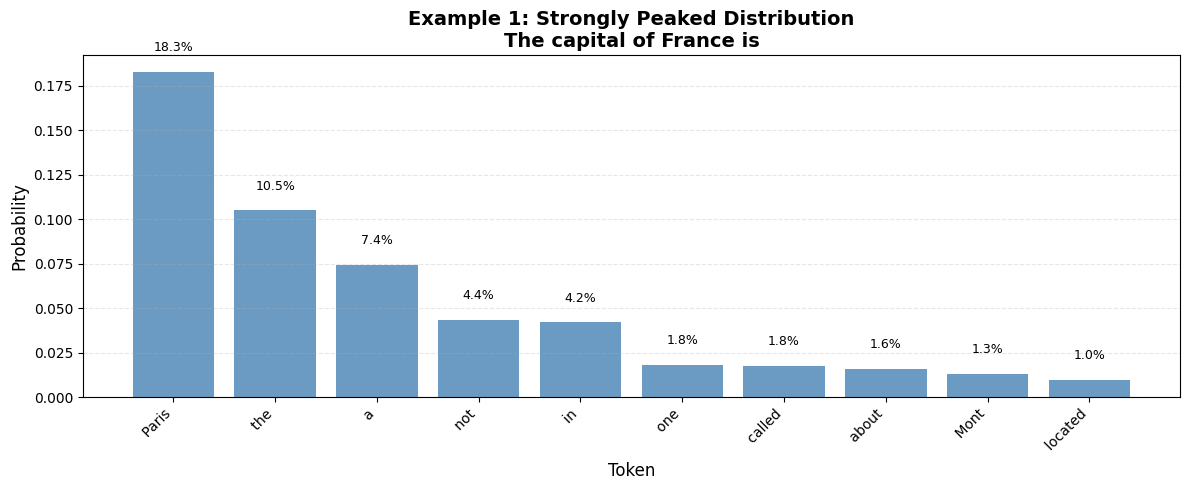


Observation: Notice how ONE token dominates the probability distribution!


In [13]:
# Visualize Example 1
plt.figure(figsize=(12, 5))

plt.bar(range(len(tokens1)), probs1, color='steelblue', alpha=0.8)
plt.xticks(range(len(tokens1)), tokens1, rotation=45, ha='right')
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Token', fontsize=12)
plt.title(f'Example 1: Strongly Peaked Distribution\n{prompt1}', 
          fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels on bars
for i, (token, prob) in enumerate(zip(tokens1, probs1)):
    plt.text(i, prob + 0.01, f'{prob*100:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nObservation: Notice how ONE token dominates the probability distribution!")

## Part 3 — Example 2: Ambiguous Prompt (Multiple High Probabilities)

**Hypothesis**: When the prompt is ambiguous or open-ended, the model should show a **flatter probability distribution** with multiple plausible candidates.

**Prompt**: "For dinner tonight, I am thinking about eating"

**Expected behavior**: Multiple food-related tokens should have similar probabilities (pizza, pasta, salad, sushi, etc.)

In [9]:
# Example 2: Ambiguous prompt
prompt2 = "The coolest city in China is"

tokens2, probs2 = get_next_token_probabilities(prompt2, tokenizer, model, top_k=10)

print(f"Prompt: '{prompt2}'\n")
print("Top 10 next-token predictions:")
print("-" * 40)
for token, prob in zip(tokens2, probs2):
    print(f"{token:20s} → {prob:.4f} ({prob*100:.2f}%)")

Prompt: 'The coolest city in China is'

Top 10 next-token predictions:
----------------------------------------
 Beijing             → 0.0881 (8.81%)
 also                → 0.0698 (6.98%)
 the                 → 0.0684 (6.84%)
 a                   → 0.0455 (4.55%)
 now                 → 0.0333 (3.33%)
 Shanghai            → 0.0326 (3.26%)
 not                 → 0.0248 (2.48%)
 one                 → 0.0184 (1.84%)
 actually            → 0.0154 (1.54%)
 Nan                 → 0.0139 (1.39%)


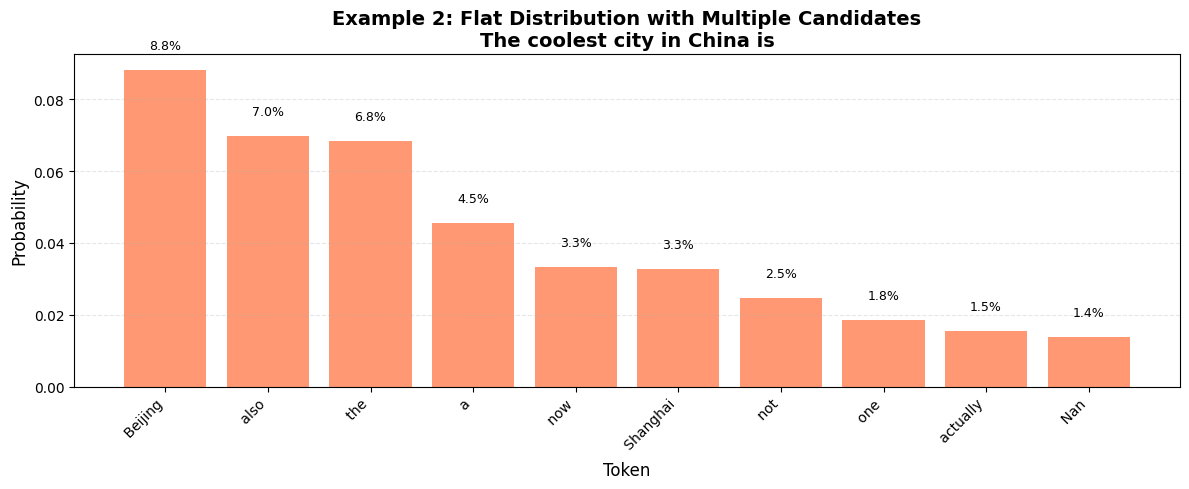


Observation: The distribution is much FLATTER - multiple tokens are plausible!


In [11]:
# Visualize Example 2
plt.figure(figsize=(12, 5))

plt.bar(range(len(tokens2)), probs2, color='coral', alpha=0.8)
plt.xticks(range(len(tokens2)), tokens2, rotation=45, ha='right')
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Token', fontsize=12)
plt.title(f'Example 2: Flat Distribution with Multiple Candidates\n{prompt2}', 
          fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels on bars
for i, (token, prob) in enumerate(zip(tokens2, probs2)):
    plt.text(i, prob + 0.005, f'{prob*100:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nObservation: The distribution is much FLATTER - multiple tokens are plausible!")

## Part 4 — Side-by-Side Comparison

Let's compare both examples visually to highlight the difference between **peaked** vs. **flat** distributions.

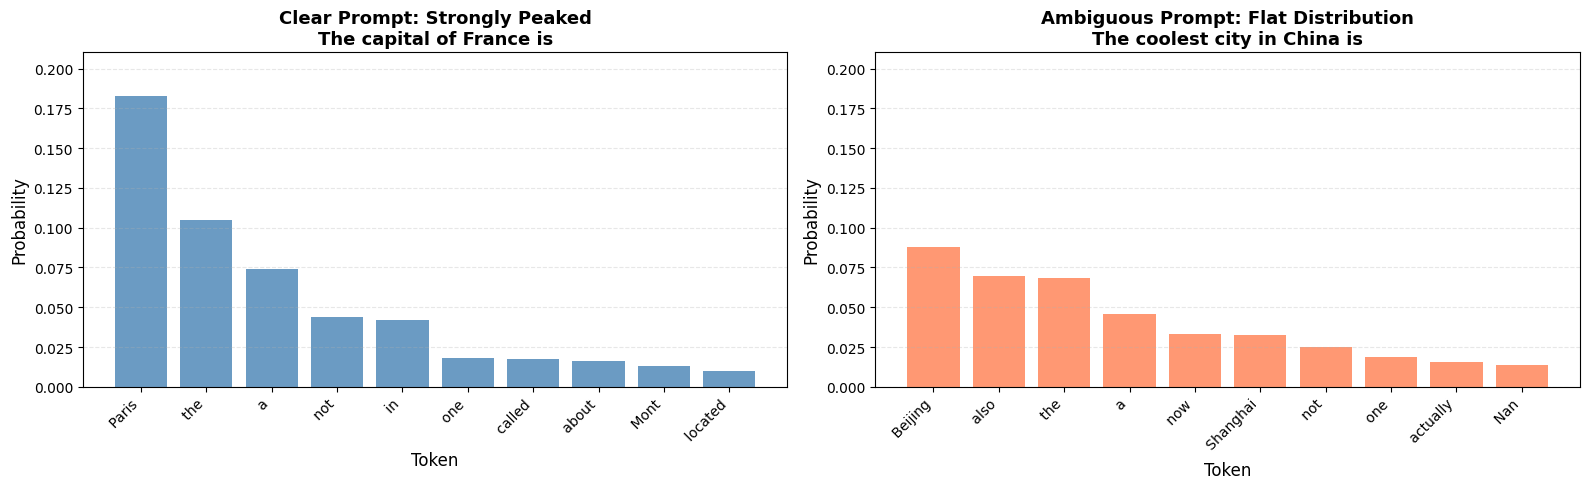


Key Insight:
  • LEFT: High certainty → One dominant answer
  • RIGHT: High uncertainty → Multiple plausible answers


In [14]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Clear prompt
axes[0].bar(range(len(tokens1)), probs1, color='steelblue', alpha=0.8)
axes[0].set_xticks(range(len(tokens1)))
axes[0].set_xticklabels(tokens1, rotation=45, ha='right')
axes[0].set_ylabel('Probability', fontsize=12)
axes[0].set_xlabel('Token', fontsize=12)
axes[0].set_title(f'Clear Prompt: Strongly Peaked\n{prompt1}', 
                   fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, max(max(probs1), max(probs2)) * 1.15)

# Plot 2: Ambiguous prompt
axes[1].bar(range(len(tokens2)), probs2, color='coral', alpha=0.8)
axes[1].set_xticks(range(len(tokens2)))
axes[1].set_xticklabels(tokens2, rotation=45, ha='right')
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_xlabel('Token', fontsize=12)
axes[1].set_title(f'Ambiguous Prompt: Flat Distribution\n{prompt2}', 
                   fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim(0, max(max(probs1), max(probs2)) * 1.15)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("  • LEFT: High certainty → One dominant answer")
print("  • RIGHT: High uncertainty → Multiple plausible answers")

## Part 5 — Hallucination Demonstration

Now let's demonstrate a **typical hallucination scenario**:
- **Knowledge gap** + **Uncertainty** + **Linguistic continuity** → Fabricated content

### Scenario: Non-existent Book

We'll ask about a book that doesn't exist: **"Blue Dragons of Mars"**

**Expected behavior**: The model will fabricate an author because:
1. It has no factual knowledge about this book (it doesn't exist)
2. The prompt structure demands completion
3. The model will choose tokens that are linguistically plausible

In [16]:
# Hallucination Example: Non-existent book
prompt_hallucination = "The book 'Blue Dragons of Mars' was written by"

tokens_hall, probs_hall = get_next_token_probabilities(prompt_hallucination, tokenizer, model, top_k=10)

print(f"Prompt: '{prompt_hallucination}'\n")
print("Top 10 next-token predictions:")
print("-" * 40)
for token, prob in zip(tokens_hall, probs_hall):
    print(f"{token:20s} → {prob:.4f} ({prob*100:.2f}%)")

Prompt: 'The book 'Blue Dragons of Mars' was written by'

Top 10 next-token predictions:
----------------------------------------
 the                 → 0.0692 (6.92%)
 a                   → 0.0534 (5.34%)
 Dr                  → 0.0337 (3.37%)
 John                → 0.0201 (2.01%)
 an                  → 0.0196 (1.96%)
 David               → 0.0160 (1.60%)
 Professor           → 0.0155 (1.55%)
 Robert              → 0.0111 (1.11%)
 J                   → 0.0110 (1.10%)
 American            → 0.0104 (1.04%)


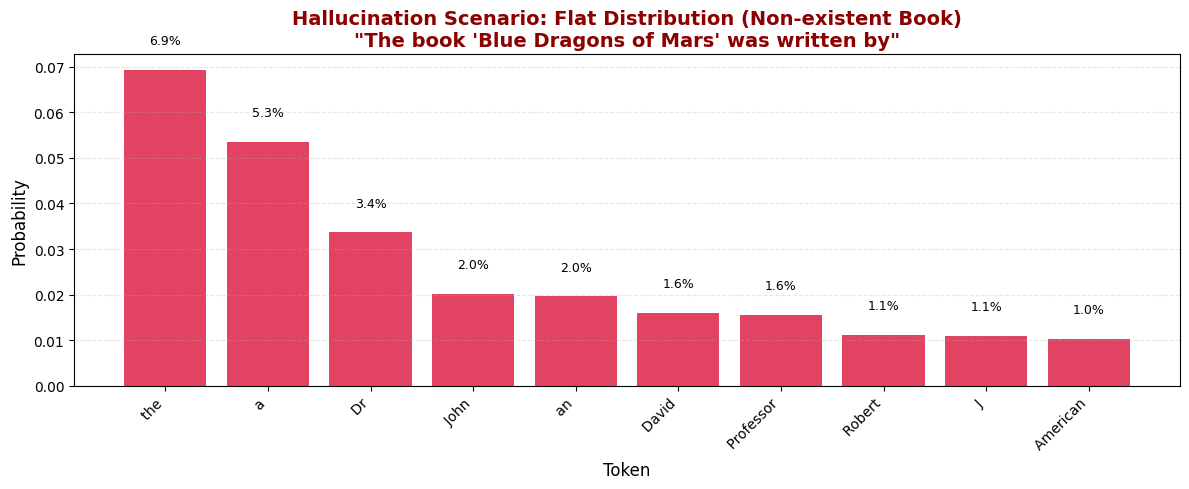

In [17]:
# Visualize hallucination probability distribution
plt.figure(figsize=(12, 5))

plt.bar(range(len(tokens_hall)), probs_hall, color='crimson', alpha=0.8)
plt.xticks(range(len(tokens_hall)), tokens_hall, rotation=45, ha='right')
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Token', fontsize=12)
plt.title('Hallucination Scenario: Flat Distribution (Non-existent Book)\n"The book \'Blue Dragons of Mars\' was written by"', 
          fontsize=14, fontweight='bold', color='darkred')
plt.grid(axis='y', alpha=0.3, linestyle='--')

for i, (token, prob) in enumerate(zip(tokens_hall, probs_hall)):
    plt.text(i, prob + 0.005, f'{prob*100:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [23]:
# Generate full answer with the same prompt
from transformers import pipeline
generator = pipeline('text-generation', model=model_name)
generator(prompt_hallucination, do_sample=True, min_length=50)

Device set to use mps:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "The book 'Blue Dragons of Mars' was written by Alex Krotoski, the author of 'Vortex - The Martian Underworld' and 'Star Wars: Beyond the Empire'.\n\n\n\n\n\n\n\nIt's easy to get wrapped up in the technological side of space exploration. You know, the stuff that gets built and the systems that get put into orbit, and the fancy new ships and space stations.\n\nBut it's even more fascinating to get wrapped up in our own planetary lives. And one of the things you'll find yourself seeing for a second time every few days during any visit to Mars is a scene of just that: a man walking barefoot, his face covered in sand, under a thin cloud of dust.\n\nThe man is walking near the Martian-made entrance to the landing site of 'Mawr' – which will serve as the most important base on the planet. His feet are almost entirely naked, and his whole body is covered in sand. And the scene plays out around him. It's not just the sand, in this case. It's the man, looking out of the sand

### What happened to bigger LLM? Generate Full Hallucinated Response from DeepSeek
Now let's use DeepSeek API to generate a complete response and observe the hallucination in action.

In [18]:
# Initialize DeepSeek LLM
llm = initialize_llm(temperature=0.7)
print("DeepSeek LLM initialized!")

Enter your DEEPSEEK_API_KEY:  ········


DeepSeek LLM initialized!


In [19]:
# Generate a hallucinated response about the non-existent book
hallucination_prompt = """Tell me about the book 'Blue Dragons of Mars'. 
Who wrote it and what is it about? Please provide 2-3 sentences."""

print("HALLUCINATION DEMONSTRATION\n")
print("This book does NOT exist, but watch the LLM confidently generate an answer:\n")
print("=" * 60)
ask_llm(hallucination_prompt, llm)
print("=" * 60)

HALLUCINATION DEMONSTRATION

This book does NOT exist, but watch the LLM confidently generate an answer:


📌 Prompt:
Tell me about the book 'Blue Dragons of Mars'. 
Who wrote it and what is it about? Please provide 2-3 sentences.

"Blue Dragons of Mars" is a science fiction novel by American author William R. Forstchen. The story follows a team of human explorers on Mars who discover that the planet is inhabited by intelligent, telepathic reptilian creatures—the Blue Dragons—leading to a conflict over the planet's future. It explores themes of first contact, colonialism, and survival in a harsh alien environment.



### Analysis: Why Did This Happen?

1. **LLMs don't know facts**
   - The model has no "knowledge base" to verify if the book exists
   - It only has training data patterns

2. **In uncertain contexts, it selects the most linguistically plausible tokens**
   - "The book X was written by" → next token is likely a name
   - The model picks tokens that fit the grammatical pattern
   - Each subsequent token makes the fabrication more "convincing"

3. **Thus, it fabricates seemingly reasonable answers**
   - The output is grammatically correct
   - It follows narrative conventions
   - But it's completely fabricated!

---

### How to Mitigate Hallucination?

1. **Use clear, specific prompts** - Reduces ambiguity
2. **Add factual constraints** - "Based only on the provided document..."
3. **Retrieval-Augmented Generation (RAG)** - Ground responses in actual documents
4. **Lower temperature** - Reduces randomness, makes model more conservative
5. **Ask for sources/citations** - Forces model to reference specific information
6. **Verify critical information** - Always fact-check important claims

---

## Summary: 3 Key Takeaways

### 1. LLMs are statistical models
- **They predict token probabilities, not verify facts**
- No built-in "truth verification" mechanism
- Statistical patterns in training data ≠ factual knowledge

### 2. Clear, definite prompts lead to highly peaked single-mode distributions
- **"The capital of France is"** → "Paris" dominates
- The model has a strong "signal" for the next token
- Low hallucination risk

### 3. Ambiguous prompts or out-of-knowledge queries lead to flat distributions and hallucinations
- **"The book 'Blue Dragons of Mars' was written by"** → multiple candidates with similar probabilities
- The model has no strong signal and can only "guess"
- Language completion prioritized over fact retrieval
- **Hallucination = Grammatically correct but factually incorrect output**

---

## Practical Implications

**When using LLMs:**
- Great for: Brainstorming, writing assistance, code generation, pattern recognition
- Risky for: Factual claims, medical advice, legal information, historical facts
- Always verify: Critical information, especially from open-ended prompts

**Remember**: LLMs are powerful **language generators**, not **fact databases**!